In [1]:
image_name = 'images/receipt_clean.png'

In [2]:
import cv2
from matplotlib import pyplot as plt
from math import ceil

def show(title, image, color=None):
    plt.figure(figsize = (15,15))
    plt.title(title)
    if color is None:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color)
    plt.show()
    
def plot_many_images(images, titles):
    columns = 4 
    rows = ceil(len(images) / columns)
    """Plots each image in a given list in a grid format using Matplotlib."""
    plt.figure(figsize = (15,10))
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.show()    

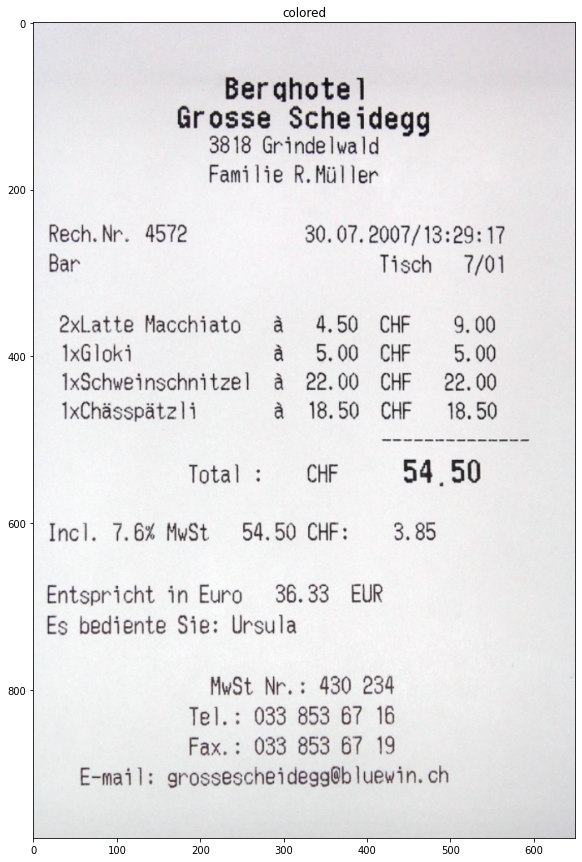

In [3]:
img = cv2.imread(image_name, 1)
show('colored', img)

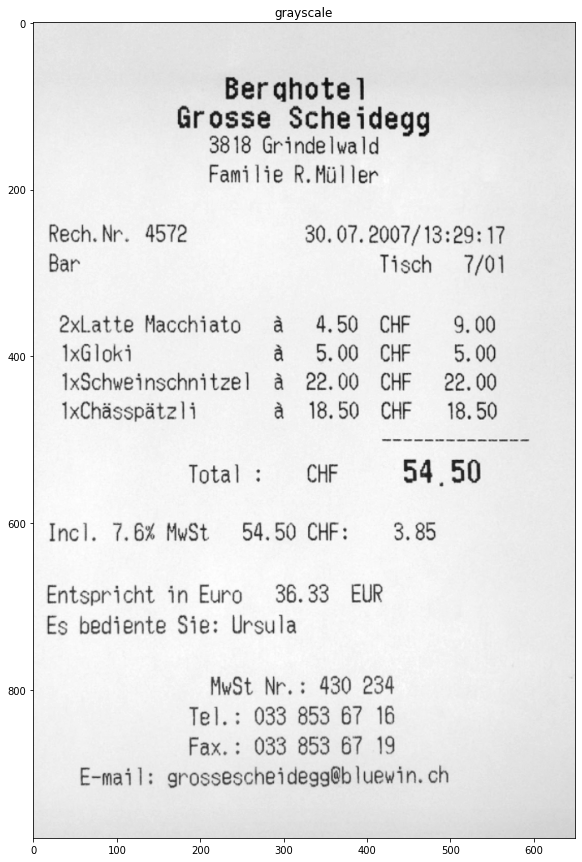

In [4]:
img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
show("grayscale", img, 'gray')

163.0
187.0


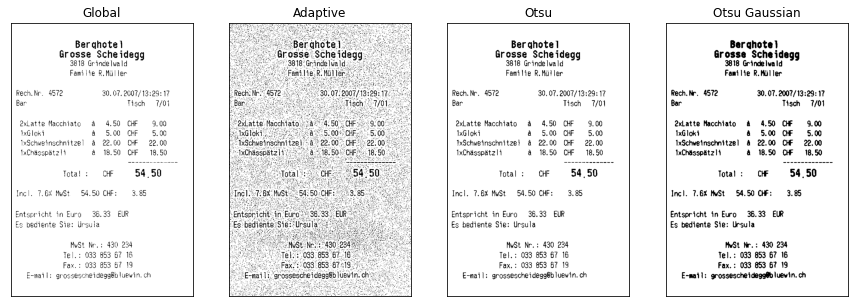

In [5]:
ret, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
ret3, th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret3)

blur = cv2.GaussianBlur(img,(5,5),0)
ret4, th4 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret4)

plot_many_images([th1, th2, th3, th4], ['Global', 'Adaptive', 'Otsu', 'Otsu Gaussian'])

In [6]:
import numpy as np

def preprocess_image(img, skip_dilate=False, skip_invert=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    if not skip_invert:
        proc = cv2.bitwise_not(proc, proc)

    if not skip_dilate:
        # Dilate the image to increase the size of the grid lines.
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
        proc = cv2.dilate(proc, kernel)

    return proc

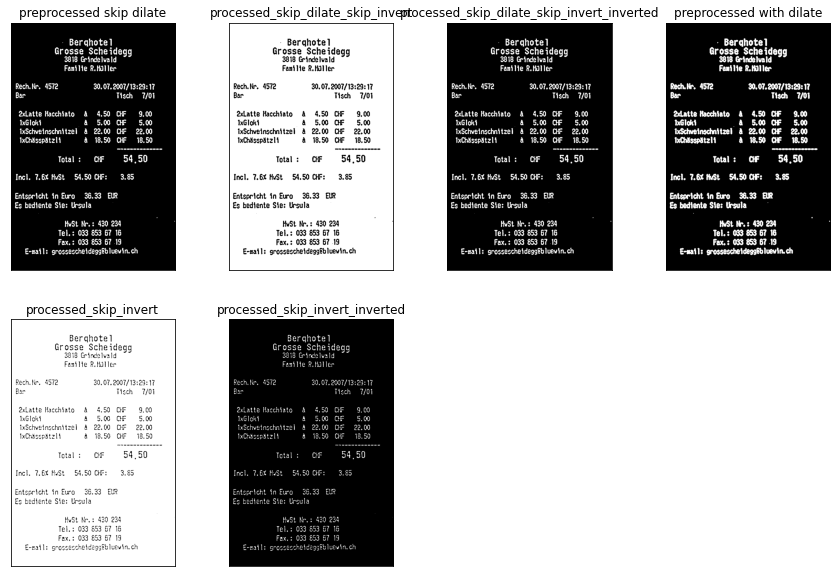

In [7]:
img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
processed_skip_dilate = preprocess_image(img, skip_dilate=True)
processed = preprocess_image(img)

# demonstration that inversion without dilation does nothing
processed_skip_dilate_skip_invert = preprocess_image(img, skip_dilate=True, skip_invert=True)
processed_skip_dilate_skip_invert_inverted = cv2.bitwise_not(processed_skip_dilate_skip_invert.copy(), processed_skip_dilate_skip_invert.copy())

# demonstration that inversion before dilation is useful
processed_skip_invert = preprocess_image(img, skip_invert=True)
processed_skip_invert_inverted = cv2.bitwise_not(processed_skip_invert.copy(), processed_skip_invert.copy())

plot_many_images([processed_skip_dilate, processed_skip_dilate_skip_invert, processed_skip_dilate_skip_invert_inverted, processed, processed_skip_invert, processed_skip_invert_inverted], 
                 ['preprocessed skip dilate', 'processed_skip_dilate_skip_invert', 'processed_skip_dilate_skip_invert_inverted',
                  'preprocessed with dilate', 'processed_skip_invert', 'processed_skip_invert_inverted'])

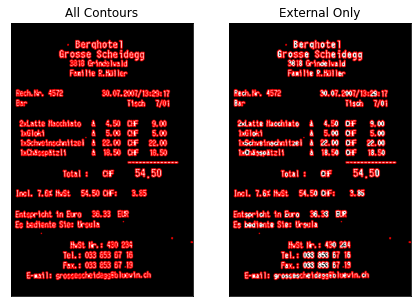

In [8]:
img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(img)

contours, new_img = cv2.findContours(processed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
ext_contours, new_img = cv2.findContours(processed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)

# Draw all of the contours on the image in 2px red lines
all_contours = cv2.drawContours(processed.copy(), contours, -1, (255, 0, 0), 2)
external_only = cv2.drawContours(processed.copy(), ext_contours, -1, (255, 0, 0), 2)
plot_many_images([all_contours, external_only], ['All Contours', 'External Only'])

In [9]:
def display_points(in_img, points, radius=5, colour=(255, 0, 0)):
    """Draws circular points on an image."""
    img = in_img.copy()

    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for point in points:
        img = cv2.circle(img.copy(), tuple(int(x) for x in point), radius, colour, -1)
        
    show("image", img)

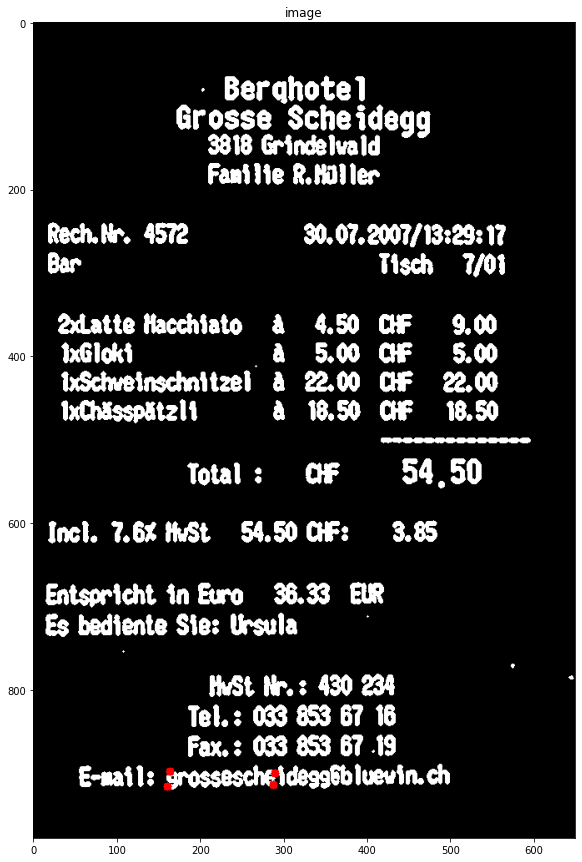

In [10]:
import operator

def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(img)
corners = find_corners_of_largest_polygon(processed)

display_points(processed, corners)

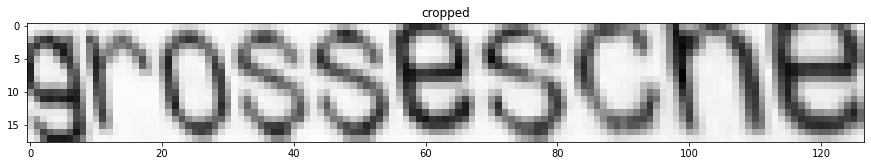

In [11]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])
    
    width = max([
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    height = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
    ])
    
    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Describe a rectangle with calculated width and height, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(width), int(height)))
  
original = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
show("cropped", cropped, "gray")

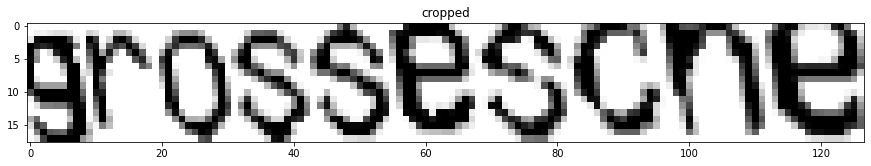

In [12]:
original = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
#proc = cv2.GaussianBlur(original, (7, 7), 0)
#blur = cv2.GaussianBlur(original,(5,5),0)
ret4, th4 = cv2.threshold(original,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Adaptive threshold using 11 nearest neighbour pixels
#proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#proc = preprocess_image(original, skip_dilate=True, skip_invert=True)

processed = preprocess_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(th4, corners)
show("cropped", cropped, "gray")